# Missing Values

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import random
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from fancyimpute import KNN, SimpleFill
from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
# from sklearn.calibration import calibration_curve
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix
# from sklearn.naive_bayes import BernoulliNB
plt.style.use('ggplot')

- look at a statistic for amount of variance reduced after imputation 
- is SVM good comparison algorithm?
- Draw actual DB of data and DB of imputed data
    - With smaller variance should have different DB shape

### Generating Data


In [92]:
n=1000
np.random.seed(1)

X,Y = datasets.make_classification(n_samples = n,
                                   n_features=3,
                                   n_redundant=0,
                                   n_informative=3,
                                   n_clusters_per_class=1,
                                   class_sep=2,
                                   random_state=3)

X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.25, random_state= 42)
X, X_test, Y, Y_test = pd.DataFrame(X), pd.DataFrame(X_test), pd.DataFrame(Y), pd.DataFrame(Y_test)



"""
arg: X is df of values
     p is prop of missing data
return: X with that prop of data missing
"""
def insertMissing(df, prop = 0.2):
    df = df.copy()
    numObs, numPred = df.shape
    for predI in range(numPred):
        missingArray = np.random.binomial(size = numObs, n = 1, p = 1-prop)
        for obsI in range(numObs):
            if not missingArray[obsI]:
                df[predI][obsI] = np.nan
    return df
    
Xmissing = insertMissing(X, 0.2)
Ymissing = insertMissing(Y, 0.2)


## Imputation

- Classes
    - Proportional
    - KNN voting
- For Features:
    - KNN 
    - Mean 
- For a given class, no values for a feature
    - LaPlace smoothing

In [21]:
# Find proportion of class 0 of Y
def classProp(df):
    sum0 = (df[0] == 0).sum()
    sum1 = (df[0] == 1).sum()
    return sum0/(sum0+sum1)

# Impute classes for binary Y by proportion of that class
def classImpute(df):
    tempDF = df.copy()
    prop0 = classProp(tempDF)
    for i in range(len(df[0])):
        if np.isnan(tempDF[0][i]):
            if random.random() > prop0:
                tempDF[0][i]= 1
            else:
                tempDF[0][i]=0
    return tempDF

In [102]:
XmeanImpute = pd.DataFrame(SimpleFill().fit_transform(Xmissing))
YpropImpute = classImpute(Ymissing)

In [103]:
#KNN imputation does its best then fills in with 0 otherwise
##Here only 6 values in each column are assigned 0
XknnImpute = pd.DataFrame(KNN(k=5).fit_transform(Xmissing))

Imputing row 1/750 with 0 missing, elapsed time: 0.104
Imputing row 101/750 with 1 missing, elapsed time: 0.106
Imputing row 201/750 with 1 missing, elapsed time: 0.108
Imputing row 301/750 with 2 missing, elapsed time: 0.110
Imputing row 401/750 with 1 missing, elapsed time: 0.112
Imputing row 501/750 with 0 missing, elapsed time: 0.114
Imputing row 601/750 with 0 missing, elapsed time: 0.115
Imputing row 701/750 with 0 missing, elapsed time: 0.117
[KNN] Warning: 21/2250 still missing after imputation, replacing with 0


In [104]:
print("XmissingSTD: %s,\n XmeanSTD: %s\n, XknnSTD: %s" % (Xmissing.std(), XmeanImpute.std(), XknnImpute.std()))

XmissingSTD: 0    2.251673
1    1.072050
2    0.818033
dtype: float64,
 XmeanSTD: 0    2.006887
1    0.954701
2    0.726648
dtype: float64
, XknnSTD: 0    2.131855
1    1.078631
2    0.798642
dtype: float64


## Naive Bayes performance

In [105]:
gnb = GaussianNB()

##TODO pass test set to function also
## right now X and Y are pandas df's
def getAccuracy(X, Y, xtest, ytest, method=gnb):
    pred = method.fit(X, Y[0]).predict(xtest)
    correct = (pred==list(ytest[0])).sum()
    return float(correct)/ytest.shape[0]

full_acc = getAccuracy(X, Y, X_test, Y_test)

print("Test Accuracy with no Missing: %s" % (full_acc))

Test Accuracy with no Missing: 0.988


### X with missing data imputed

In [106]:
XmeanImpute.shape

meanImpute_acc = getAccuracy(XmeanImpute, Y, X_test, Y_test)
print("Accuracy on X mean impute: %s \n" % (meanImpute_acc))

knnImpute_acc = getAccuracy(XknnImpute, Y, X_test, Y_test)
print("Accuracy on X knn impute: %s" % (knnImpute_acc))

Accuracy on X mean impute: 0.988 

Accuracy on X knn impute: 0.988


   #### Getting a range of imputed data for X

In [119]:
def makeMissingList(X, Y, props):
    X_missing_list = list()
    
    for i in props:
        newMissX = insertMissing(X, i)
        X_missing_list.append(newMissX)
    
    return X_missing_list

def getMissingAccuracies(X, Y, props, impute = 'mean', method=gnb):
    imputeFunction = SimpleFill().fit_transform if impute == 'mean' else KNN(k=10).fit_transform
    X_missing_list = makeMissingList(X, Y, props)
    
    missing_acc = list()
    for x in X_missing_list:
        x_imputed = pd.DataFrame(imputeFunction(x))
        ### TODO should have X_test and Y_test as parameters
        acc = getAccuracy(x_imputed, Y, X_test, Y_test, method)
        missing_acc.append(acc)
    
    ### concat accuracy list and np.arange
    acc_df = pd.concat([pd.Series(props), pd.Series(missing_acc)], axis=1)
    return acc_df

#### Logistic Regression

In [122]:
x_miss_list = makeMissingList(X, Y, np.arange(0,1,0.02))
lr = LogisticRegression(solver="lbfgs")

lrFullModel = lr.fit(X, Y[0])
lrFullPred = lrFullModel.predict(X_test)

lrFullAcc = np.sum(lrFullPred == Y_test[0])/len(Y_test)
print("Log Reg acc on test X, no missing: ", lrFullAcc)

Log Reg acc on test X, no missing:  0.992


#### SVM

In [123]:
svm = LinearSVC()
svmFullModel = svm.fit(X, Y[0])
svmFullPred = svmFullModel.predict(X_test)

svmFullAcc = np.sum(svmFullPred==Y_test[0])/len(Y_test)
print("SVM acc on full X, no missing: ", svmFullAcc)

SVM acc on full X, no missing:  0.988


### Plot of Accuracy vs Prop of Missing Data Imputed 
##### Mean Impute

In [124]:
%%capture
acc_mean_gnb = getMissingAccuracies(X, Y, np.arange(0,1,0.02))
acc_mean_lr = getMissingAccuracies(X, Y, np.arange(0,1,0.02), method=lr)
acc_mean_svm = getMissingAccuracies(X, Y, np.arange(0,1,0.02), method=svm)

Text(0.5, 1.0, 'Accuracy on Mean imputed')

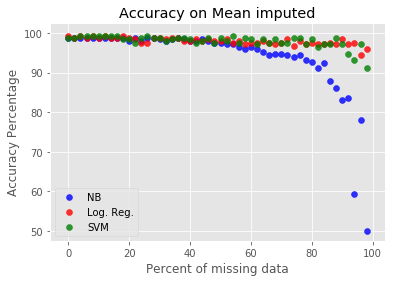

In [118]:
plt.scatter(x=(np.arange(0,1,0.02)*100), y=(acc_mean_gnb[1]*100), c="blue", label="NB", alpha=0.8)
plt.scatter(x=(np.arange(0,1,0.02)*100), y=(acc_mean_lr[1]*100), c='red', label="Log. Reg.", alpha=0.8)
plt.scatter(x=(np.arange(0,1,0.02)*100), y=(acc_mean_svm[1]*100), c='green', label="SVM", alpha=0.8)
plt.legend()
plt.xlabel("Percent of missing data")
plt.ylabel("Accuracy Percentage")
plt.title("Accuracy on Mean imputed")

##### KNN Impute (K=10)

In [120]:
acc_knn_gnb = getMissingAccuracies(X, Y, np.arange(0,1,0.02), impute="KNN")
acc_knn_lr = getMissingAccuracies(X, Y, np.arange(0,1,0.02), impute="KNN", method = lr)
acc_knn_svm = getMissingAccuracies(X, Y, np.arange(0,1,0.02), impute="KNN", method = svm)

/anaconda2/envs/New3/lib/python3.7/site-packages/fancyimpute/solver.py:58: UserWarning: Input matrix is not missing any values
  warnings.warn("Input matrix is not missing any values")


Imputing row 1/750 with 0 missing, elapsed time: 0.070
Imputing row 101/750 with 0 missing, elapsed time: 0.071
Imputing row 201/750 with 0 missing, elapsed time: 0.071
Imputing row 301/750 with 0 missing, elapsed time: 0.071
Imputing row 401/750 with 0 missing, elapsed time: 0.072
Imputing row 501/750 with 0 missing, elapsed time: 0.072
Imputing row 601/750 with 0 missing, elapsed time: 0.072
Imputing row 701/750 with 0 missing, elapsed time: 0.073
Imputing row 1/750 with 0 missing, elapsed time: 0.070
Imputing row 101/750 with 0 missing, elapsed time: 0.071
Imputing row 201/750 with 0 missing, elapsed time: 0.072
Imputing row 301/750 with 0 missing, elapsed time: 0.072
Imputing row 401/750 with 0 missing, elapsed time: 0.073
Imputing row 501/750 with 0 missing, elapsed time: 0.074
Imputing row 601/750 with 0 missing, elapsed time: 0.075
Imputing row 701/750 with 0 missing, elapsed time: 0.075
Imputing row 1/750 with 0 missing, elapsed time: 0.080
Imputing row 101/750 with 0 missing, 

Imputing row 1/750 with 0 missing, elapsed time: 0.086
Imputing row 101/750 with 1 missing, elapsed time: 0.090
Imputing row 201/750 with 1 missing, elapsed time: 0.093
Imputing row 301/750 with 3 missing, elapsed time: 0.096
Imputing row 401/750 with 2 missing, elapsed time: 0.099
Imputing row 501/750 with 2 missing, elapsed time: 0.102
Imputing row 601/750 with 1 missing, elapsed time: 0.104
Imputing row 701/750 with 1 missing, elapsed time: 0.106
[KNN] Warning: 105/2250 still missing after imputation, replacing with 0
Imputing row 1/750 with 1 missing, elapsed time: 0.087
Imputing row 101/750 with 2 missing, elapsed time: 0.089
Imputing row 201/750 with 2 missing, elapsed time: 0.092
Imputing row 301/750 with 1 missing, elapsed time: 0.095
Imputing row 401/750 with 1 missing, elapsed time: 0.097
Imputing row 501/750 with 3 missing, elapsed time: 0.100
Imputing row 601/750 with 0 missing, elapsed time: 0.102
Imputing row 701/750 with 1 missing, elapsed time: 0.105
[KNN] Warning: 120/

Imputing row 1/750 with 1 missing, elapsed time: 0.063
Imputing row 101/750 with 2 missing, elapsed time: 0.068
Imputing row 201/750 with 3 missing, elapsed time: 0.072
Imputing row 301/750 with 2 missing, elapsed time: 0.076
Imputing row 401/750 with 2 missing, elapsed time: 0.080
Imputing row 501/750 with 2 missing, elapsed time: 0.083
Imputing row 601/750 with 3 missing, elapsed time: 0.087
Imputing row 701/750 with 2 missing, elapsed time: 0.091
[KNN] Warning: 756/2250 still missing after imputation, replacing with 0
Imputing row 1/750 with 2 missing, elapsed time: 0.059
Imputing row 101/750 with 2 missing, elapsed time: 0.063
Imputing row 201/750 with 3 missing, elapsed time: 0.067
Imputing row 301/750 with 2 missing, elapsed time: 0.071
Imputing row 401/750 with 2 missing, elapsed time: 0.076
Imputing row 501/750 with 3 missing, elapsed time: 0.080
Imputing row 601/750 with 2 missing, elapsed time: 0.084
Imputing row 701/750 with 2 missing, elapsed time: 0.088
[KNN] Warning: 780/

Imputing row 501/750 with 3 missing, elapsed time: 0.030
Imputing row 601/750 with 3 missing, elapsed time: 0.032
Imputing row 701/750 with 3 missing, elapsed time: 0.035
[KNN] Warning: 2158/2250 still missing after imputation, replacing with 0


/anaconda2/envs/New3/lib/python3.7/site-packages/fancyimpute/solver.py:58: UserWarning: Input matrix is not missing any values
  warnings.warn("Input matrix is not missing any values")


Imputing row 1/750 with 0 missing, elapsed time: 0.072
Imputing row 101/750 with 0 missing, elapsed time: 0.072
Imputing row 201/750 with 0 missing, elapsed time: 0.072
Imputing row 301/750 with 0 missing, elapsed time: 0.073
Imputing row 401/750 with 0 missing, elapsed time: 0.073
Imputing row 501/750 with 0 missing, elapsed time: 0.073
Imputing row 601/750 with 0 missing, elapsed time: 0.074
Imputing row 701/750 with 0 missing, elapsed time: 0.074
Imputing row 1/750 with 0 missing, elapsed time: 0.073
Imputing row 101/750 with 0 missing, elapsed time: 0.074
Imputing row 201/750 with 0 missing, elapsed time: 0.076
Imputing row 301/750 with 0 missing, elapsed time: 0.076
Imputing row 401/750 with 0 missing, elapsed time: 0.077
Imputing row 501/750 with 0 missing, elapsed time: 0.078
Imputing row 601/750 with 0 missing, elapsed time: 0.080
Imputing row 701/750 with 1 missing, elapsed time: 0.081
Imputing row 1/750 with 0 missing, elapsed time: 0.084
Imputing row 101/750 with 0 missing, 

Imputing row 1/750 with 0 missing, elapsed time: 0.094
Imputing row 101/750 with 0 missing, elapsed time: 0.097
Imputing row 201/750 with 2 missing, elapsed time: 0.099
Imputing row 301/750 with 1 missing, elapsed time: 0.102
Imputing row 401/750 with 3 missing, elapsed time: 0.105
Imputing row 501/750 with 1 missing, elapsed time: 0.107
Imputing row 601/750 with 1 missing, elapsed time: 0.110
Imputing row 701/750 with 0 missing, elapsed time: 0.113
[KNN] Warning: 120/2250 still missing after imputation, replacing with 0
Imputing row 1/750 with 1 missing, elapsed time: 0.089
Imputing row 101/750 with 1 missing, elapsed time: 0.092
Imputing row 201/750 with 2 missing, elapsed time: 0.094
Imputing row 301/750 with 1 missing, elapsed time: 0.097
Imputing row 401/750 with 0 missing, elapsed time: 0.100
Imputing row 501/750 with 2 missing, elapsed time: 0.102
Imputing row 601/750 with 2 missing, elapsed time: 0.105
Imputing row 701/750 with 1 missing, elapsed time: 0.107
[KNN] Warning: 135/

Imputing row 1/750 with 1 missing, elapsed time: 0.089
Imputing row 101/750 with 1 missing, elapsed time: 0.093
Imputing row 201/750 with 3 missing, elapsed time: 0.097
Imputing row 301/750 with 2 missing, elapsed time: 0.102
Imputing row 401/750 with 3 missing, elapsed time: 0.106
Imputing row 501/750 with 2 missing, elapsed time: 0.111
Imputing row 601/750 with 2 missing, elapsed time: 0.117
Imputing row 701/750 with 3 missing, elapsed time: 0.122
[KNN] Warning: 744/2250 still missing after imputation, replacing with 0
Imputing row 1/750 with 2 missing, elapsed time: 0.076
Imputing row 101/750 with 1 missing, elapsed time: 0.081
Imputing row 201/750 with 2 missing, elapsed time: 0.086
Imputing row 301/750 with 2 missing, elapsed time: 0.090
Imputing row 401/750 with 1 missing, elapsed time: 0.094
Imputing row 501/750 with 2 missing, elapsed time: 0.098
Imputing row 601/750 with 2 missing, elapsed time: 0.103
Imputing row 701/750 with 3 missing, elapsed time: 0.107
[KNN] Warning: 756/

/anaconda2/envs/New3/lib/python3.7/site-packages/fancyimpute/solver.py:58: UserWarning: Input matrix is not missing any values
  warnings.warn("Input matrix is not missing any values")


Imputing row 1/750 with 0 missing, elapsed time: 0.076
Imputing row 101/750 with 0 missing, elapsed time: 0.076
Imputing row 201/750 with 0 missing, elapsed time: 0.077
Imputing row 301/750 with 0 missing, elapsed time: 0.077
Imputing row 401/750 with 0 missing, elapsed time: 0.077
Imputing row 501/750 with 0 missing, elapsed time: 0.077
Imputing row 601/750 with 0 missing, elapsed time: 0.078
Imputing row 701/750 with 0 missing, elapsed time: 0.078
Imputing row 1/750 with 0 missing, elapsed time: 0.075
Imputing row 101/750 with 0 missing, elapsed time: 0.076
Imputing row 201/750 with 0 missing, elapsed time: 0.077
Imputing row 301/750 with 0 missing, elapsed time: 0.078
Imputing row 401/750 with 0 missing, elapsed time: 0.079
Imputing row 501/750 with 1 missing, elapsed time: 0.080
Imputing row 601/750 with 0 missing, elapsed time: 0.080
Imputing row 701/750 with 0 missing, elapsed time: 0.081
Imputing row 1/750 with 0 missing, elapsed time: 0.075
Imputing row 101/750 with 0 missing, 

/anaconda2/envs/New3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Imputing row 1/750 with 1 missing, elapsed time: 0.088
Imputing row 101/750 with 0 missing, elapsed time: 0.091
Imputing row 201/750 with 0 missing, elapsed time: 0.093
Imputing row 301/750 with 0 missing, elapsed time: 0.095
Imputing row 401/750 with 0 missing, elapsed time: 0.098
Imputing row 501/750 with 0 missing, elapsed time: 0.100
Imputing row 601/750 with 1 missing, elapsed time: 0.102
Imputing row 701/750 with 0 missing, elapsed time: 0.104
[KNN] Warning: 33/2250 still missing after imputation, replacing with 0
Imputing row 1/750 with 1 missing, elapsed time: 0.084
Imputing row 101/750 with 0 missing, elapsed time: 0.085
Imputing row 201/750 with 0 missing, elapsed time: 0.087
Imputing row 301/750 with 0 missing, elapsed time: 0.089
Imputing row 401/750 with 0 missing, elapsed time: 0.091
Imputing row 501/750 with 1 missing, elapsed time: 0.093
Imputing row 601/750 with 1 missing, elapsed time: 0.095
Imputing row 701/750 with 0 missing, elapsed time: 0.097
[KNN] Warning: 15/22

/anaconda2/envs/New3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Imputing row 1/750 with 2 missing, elapsed time: 0.086
Imputing row 101/750 with 1 missing, elapsed time: 0.089
Imputing row 201/750 with 1 missing, elapsed time: 0.093
Imputing row 301/750 with 0 missing, elapsed time: 0.094
Imputing row 401/750 with 1 missing, elapsed time: 0.096
Imputing row 501/750 with 0 missing, elapsed time: 0.099
Imputing row 601/750 with 0 missing, elapsed time: 0.103
Imputing row 701/750 with 1 missing, elapsed time: 0.106
[KNN] Warning: 21/2250 still missing after imputation, replacing with 0
Imputing row 1/750 with 2 missing, elapsed time: 0.084
Imputing row 101/750 with 1 missing, elapsed time: 0.086
Imputing row 201/750 with 2 missing, elapsed time: 0.088
Imputing row 301/750 with 1 missing, elapsed time: 0.090
Imputing row 401/750 with 0 missing, elapsed time: 0.092
Imputing row 501/750 with 0 missing, elapsed time: 0.094
Imputing row 601/750 with 1 missing, elapsed time: 0.096
Imputing row 701/750 with 0 missing, elapsed time: 0.098
[KNN] Warning: 45/22

/anaconda2/envs/New3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda2/envs/New3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Imputing row 1/750 with 1 missing, elapsed time: 0.101
Imputing row 101/750 with 1 missing, elapsed time: 0.103
Imputing row 201/750 with 1 missing, elapsed time: 0.107
Imputing row 301/750 with 1 missing, elapsed time: 0.111
Imputing row 401/750 with 1 missing, elapsed time: 0.114
Imputing row 501/750 with 0 missing, elapsed time: 0.116
Imputing row 601/750 with 1 missing, elapsed time: 0.118
Imputing row 701/750 with 0 missing, elapsed time: 0.121
[KNN] Warning: 54/2250 still missing after imputation, replacing with 0
Imputing row 1/750 with 1 missing, elapsed time: 0.098
Imputing row 101/750 with 1 missing, elapsed time: 0.100
Imputing row 201/750 with 1 missing, elapsed time: 0.103
Imputing row 301/750 with 1 missing, elapsed time: 0.105
Imputing row 401/750 with 0 missing, elapsed time: 0.109
Imputing row 501/750 with 1 missing, elapsed time: 0.112
Imputing row 601/750 with 0 missing, elapsed time: 0.114
Imputing row 701/750 with 0 missing, elapsed time: 0.116
[KNN] Warning: 75/22

/anaconda2/envs/New3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda2/envs/New3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Imputing row 1/750 with 2 missing, elapsed time: 0.100
Imputing row 101/750 with 0 missing, elapsed time: 0.105
Imputing row 201/750 with 1 missing, elapsed time: 0.109
Imputing row 301/750 with 3 missing, elapsed time: 0.112
Imputing row 401/750 with 1 missing, elapsed time: 0.115
Imputing row 501/750 with 1 missing, elapsed time: 0.120
Imputing row 601/750 with 1 missing, elapsed time: 0.123
Imputing row 701/750 with 1 missing, elapsed time: 0.126
[KNN] Warning: 114/2250 still missing after imputation, replacing with 0
Imputing row 1/750 with 1 missing, elapsed time: 0.095
Imputing row 101/750 with 1 missing, elapsed time: 0.097
Imputing row 201/750 with 1 missing, elapsed time: 0.100
Imputing row 301/750 with 2 missing, elapsed time: 0.103
Imputing row 401/750 with 1 missing, elapsed time: 0.107
Imputing row 501/750 with 1 missing, elapsed time: 0.110
Imputing row 601/750 with 1 missing, elapsed time: 0.113
Imputing row 701/750 with 1 missing, elapsed time: 0.116
[KNN] Warning: 222/

/anaconda2/envs/New3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda2/envs/New3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Imputing row 1/750 with 3 missing, elapsed time: 0.095
Imputing row 101/750 with 1 missing, elapsed time: 0.099
Imputing row 201/750 with 0 missing, elapsed time: 0.102
Imputing row 301/750 with 1 missing, elapsed time: 0.106
Imputing row 401/750 with 0 missing, elapsed time: 0.109
Imputing row 501/750 with 1 missing, elapsed time: 0.113
Imputing row 601/750 with 2 missing, elapsed time: 0.117
Imputing row 701/750 with 2 missing, elapsed time: 0.120
[KNN] Warning: 306/2250 still missing after imputation, replacing with 0
Imputing row 1/750 with 2 missing, elapsed time: 0.087
Imputing row 101/750 with 1 missing, elapsed time: 0.090
Imputing row 201/750 with 3 missing, elapsed time: 0.093
Imputing row 301/750 with 1 missing, elapsed time: 0.096
Imputing row 401/750 with 2 missing, elapsed time: 0.101
Imputing row 501/750 with 1 missing, elapsed time: 0.105
Imputing row 601/750 with 0 missing, elapsed time: 0.108
Imputing row 701/750 with 1 missing, elapsed time: 0.111
[KNN] Warning: 354/

/anaconda2/envs/New3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Imputing row 1/750 with 2 missing, elapsed time: 0.100
Imputing row 101/750 with 2 missing, elapsed time: 0.103
Imputing row 201/750 with 1 missing, elapsed time: 0.107
Imputing row 301/750 with 1 missing, elapsed time: 0.111
Imputing row 401/750 with 1 missing, elapsed time: 0.115
Imputing row 501/750 with 2 missing, elapsed time: 0.118
Imputing row 601/750 with 2 missing, elapsed time: 0.121
Imputing row 701/750 with 1 missing, elapsed time: 0.125
[KNN] Warning: 375/2250 still missing after imputation, replacing with 0
Imputing row 1/750 with 0 missing, elapsed time: 0.082
Imputing row 101/750 with 1 missing, elapsed time: 0.086
Imputing row 201/750 with 1 missing, elapsed time: 0.090
Imputing row 301/750 with 2 missing, elapsed time: 0.093
Imputing row 401/750 with 2 missing, elapsed time: 0.098
Imputing row 501/750 with 1 missing, elapsed time: 0.101
Imputing row 601/750 with 2 missing, elapsed time: 0.105
Imputing row 701/750 with 1 missing, elapsed time: 0.110
[KNN] Warning: 435/

/anaconda2/envs/New3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Imputing row 1/750 with 2 missing, elapsed time: 0.075
Imputing row 101/750 with 1 missing, elapsed time: 0.079
Imputing row 201/750 with 2 missing, elapsed time: 0.083
Imputing row 301/750 with 2 missing, elapsed time: 0.086
Imputing row 401/750 with 3 missing, elapsed time: 0.091
Imputing row 501/750 with 1 missing, elapsed time: 0.095
Imputing row 601/750 with 2 missing, elapsed time: 0.099
Imputing row 701/750 with 2 missing, elapsed time: 0.103
[KNN] Warning: 702/2250 still missing after imputation, replacing with 0
Imputing row 1/750 with 3 missing, elapsed time: 0.070
Imputing row 101/750 with 0 missing, elapsed time: 0.074
Imputing row 201/750 with 2 missing, elapsed time: 0.080
Imputing row 301/750 with 2 missing, elapsed time: 0.085
Imputing row 401/750 with 1 missing, elapsed time: 0.089
Imputing row 501/750 with 3 missing, elapsed time: 0.094
Imputing row 601/750 with 2 missing, elapsed time: 0.098
Imputing row 701/750 with 3 missing, elapsed time: 0.103
[KNN] Warning: 822/

/anaconda2/envs/New3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Imputing row 1/750 with 3 missing, elapsed time: 0.067
Imputing row 101/750 with 2 missing, elapsed time: 0.070
Imputing row 201/750 with 2 missing, elapsed time: 0.074
Imputing row 301/750 with 2 missing, elapsed time: 0.078
Imputing row 401/750 with 3 missing, elapsed time: 0.081
Imputing row 501/750 with 2 missing, elapsed time: 0.085
Imputing row 601/750 with 2 missing, elapsed time: 0.089
Imputing row 701/750 with 2 missing, elapsed time: 0.092
[KNN] Warning: 807/2250 still missing after imputation, replacing with 0
Imputing row 1/750 with 3 missing, elapsed time: 0.059
Imputing row 101/750 with 3 missing, elapsed time: 0.064
Imputing row 201/750 with 3 missing, elapsed time: 0.068
Imputing row 301/750 with 2 missing, elapsed time: 0.072
Imputing row 401/750 with 3 missing, elapsed time: 0.077
Imputing row 501/750 with 3 missing, elapsed time: 0.080
Imputing row 601/750 with 2 missing, elapsed time: 0.084
Imputing row 701/750 with 2 missing, elapsed time: 0.089
[KNN] Warning: 903/

/anaconda2/envs/New3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Imputing row 1/750 with 2 missing, elapsed time: 0.050
Imputing row 101/750 with 2 missing, elapsed time: 0.055
Imputing row 201/750 with 1 missing, elapsed time: 0.059
Imputing row 301/750 with 2 missing, elapsed time: 0.065
Imputing row 401/750 with 1 missing, elapsed time: 0.069
Imputing row 501/750 with 2 missing, elapsed time: 0.073
Imputing row 601/750 with 3 missing, elapsed time: 0.077
Imputing row 701/750 with 3 missing, elapsed time: 0.084
[KNN] Warning: 1152/2250 still missing after imputation, replacing with 0
Imputing row 1/750 with 1 missing, elapsed time: 0.040
Imputing row 101/750 with 2 missing, elapsed time: 0.045
Imputing row 201/750 with 3 missing, elapsed time: 0.049
Imputing row 301/750 with 2 missing, elapsed time: 0.053
Imputing row 401/750 with 3 missing, elapsed time: 0.056
Imputing row 501/750 with 2 missing, elapsed time: 0.060
Imputing row 601/750 with 3 missing, elapsed time: 0.066
Imputing row 701/750 with 3 missing, elapsed time: 0.071
[KNN] Warning: 134

/anaconda2/envs/New3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Imputing row 101/750 with 3 missing, elapsed time: 0.045
Imputing row 201/750 with 3 missing, elapsed time: 0.049
Imputing row 301/750 with 3 missing, elapsed time: 0.053
Imputing row 401/750 with 1 missing, elapsed time: 0.058
Imputing row 501/750 with 3 missing, elapsed time: 0.062
Imputing row 601/750 with 2 missing, elapsed time: 0.065
Imputing row 701/750 with 3 missing, elapsed time: 0.070
[KNN] Warning: 1341/2250 still missing after imputation, replacing with 0
Imputing row 1/750 with 3 missing, elapsed time: 0.040
Imputing row 101/750 with 3 missing, elapsed time: 0.044
Imputing row 201/750 with 3 missing, elapsed time: 0.050
Imputing row 301/750 with 3 missing, elapsed time: 0.056
Imputing row 401/750 with 2 missing, elapsed time: 0.061
Imputing row 501/750 with 3 missing, elapsed time: 0.064
Imputing row 601/750 with 3 missing, elapsed time: 0.068
Imputing row 701/750 with 2 missing, elapsed time: 0.072
[KNN] Warning: 1425/2250 still missing after imputation, replacing with 0

/anaconda2/envs/New3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda2/envs/New3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



Imputing row 501/750 with 3 missing, elapsed time: 0.059
Imputing row 601/750 with 3 missing, elapsed time: 0.062
Imputing row 701/750 with 3 missing, elapsed time: 0.067
[KNN] Warning: 1542/2250 still missing after imputation, replacing with 0
Imputing row 1/750 with 3 missing, elapsed time: 0.035
Imputing row 101/750 with 3 missing, elapsed time: 0.038
Imputing row 201/750 with 2 missing, elapsed time: 0.042
Imputing row 301/750 with 2 missing, elapsed time: 0.046
Imputing row 401/750 with 3 missing, elapsed time: 0.050
Imputing row 501/750 with 3 missing, elapsed time: 0.054
Imputing row 601/750 with 3 missing, elapsed time: 0.057
Imputing row 701/750 with 3 missing, elapsed time: 0.062
[KNN] Warning: 1599/2250 still missing after imputation, replacing with 0
Imputing row 1/750 with 3 missing, elapsed time: 0.029
Imputing row 101/750 with 3 missing, elapsed time: 0.034
Imputing row 201/750 with 3 missing, elapsed time: 0.039
Imputing row 301/750 with 3 missing, elapsed time: 0.044


Text(0.5, 1.0, 'Accuracy on KNN imputed')

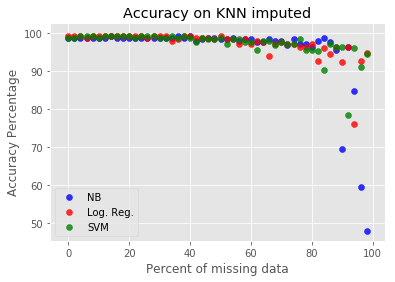

In [121]:
plt.scatter(x=(np.arange(0,1,0.02)*100), y=(acc_knn_gnb[1]*100), c="blue", label="NB", alpha=0.8)
plt.scatter(x=(np.arange(0,1,0.02)*100), y=(acc_knn_lr[1]*100), c='red', label="Log. Reg.", alpha=0.8)
plt.scatter(x=(np.arange(0,1,0.02)*100), y=(acc_knn_svm[1]*100), c='green', label="SVM", alpha=0.8)
plt.legend()
plt.xlabel("Percent of missing data")
plt.ylabel("Accuracy Percentage")
plt.title("Accuracy on KNN imputed")

## Y with missing data imputed

In [64]:
yPropImpute_acc = getTrainAccuracy(X, YpropImpute)
print("Accuracy with proportional Y imputed:  %s" % (yPropImpute_acc))

Accuracy with proportional Y imputed:  0.936


## Conclusions

**Variance**
- changes when impute (especially mean impute)
    - where will it misclassify new points?
- class impute effect?

